# This notebooking is for training Modified DETR model for Multi-MNIST

In [50]:
import math
import os
import pandas as pd
import seaborn as sns
import pickle
import datetime
import json
import random
import time
from pathlib import Path
import numpy as np
from PIL import Image
import requests
from collections import OrderedDict
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision.models._utils import IntermediateLayerGetter

try:
    import dotmap
except:
  !pip install dotmap
  import dotmap

if not os.path.exists('detr'):
  !git clone https://github.com/rarefin/detr.git --single-branch --branch multi-mnist

import sys
sys.path.append('detr')

import util.misc as utils
from util.misc import NestedTensor
from models.position_encoding import build_position_encoding
from models.matcher import build_matcher
from models.transformer import build_transformer
from models.detr import DETR, PostProcess, SetCriterion
from engine import evaluate, train_one_epoch

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## I made some modification in the architecture:
#### As a backbone model, I used resnet18. Modification in the backbone:
* As the images are 64x64, I removed the stided convolution in 1st layer and deleted the max pooling layer  

#### In Transformer:
    * Number of Encoding layer: 2
    * Number of Decoding layer: 2
    * Hidden dim: 128
    * Number of heads: 4
    * Number of queries: 10

### Backbone model code is shown in this notebook (Other parts are imported from the repo)

In [36]:
class FrozenBatchNorm2d(torch.nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.

    Copy-paste from torchvision.misc.ops with added eps before rqsrt,
    without which any other models than torchvision.models.resnet[18,34,50,101]
    produce nans.
    """

    def __init__(self, n):
        super(FrozenBatchNorm2d, self).__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        num_batches_tracked_key = prefix + 'num_batches_tracked'
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super(FrozenBatchNorm2d, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

    def forward(self, x):
        # move reshapes to the beginning
        # to make it fuser-friendly
        w = self.weight.reshape(1, -1, 1, 1)
        b = self.bias.reshape(1, -1, 1, 1)
        rv = self.running_var.reshape(1, -1, 1, 1)
        rm = self.running_mean.reshape(1, -1, 1, 1)
        eps = 1e-5
        scale = w * (rv + eps).rsqrt()
        bias = b - rm * scale
        return x * scale + bias


class BackboneBase(nn.Module):

    def __init__(self, backbone: nn.Module, train_backbone: bool, num_channels: int, return_interm_layers: bool):
        super().__init__()
        for name, parameter in backbone.named_parameters():
            if not train_backbone or 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                parameter.requires_grad_(False)
        if return_interm_layers:
            return_layers = {"layer1": "0", "layer2": "1", "layer3": "2", "layer4": "3"}
        else:
            return_layers = {'layer4': 0}
        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        # Remving strided convolution and setting input channels as 1
        self.body.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(3, 3), bias=False)
        # Removing max pooling layer
        del self.body.maxpool
        self.num_channels = num_channels

    def forward(self, tensor_list):
        xs = self.body(tensor_list.tensors)
        out = OrderedDict()
        for name, x in xs.items():
            mask = F.interpolate(tensor_list.mask[None].float(), size=x.shape[-2:]).bool()[0]
            out[name] = NestedTensor(x, mask)
        return out


class Backbone(BackboneBase):
    """ResNet backbone with frozen BatchNorm."""
    def __init__(self, name: str,
                 train_backbone: bool,
                 return_interm_layers: bool,
                 dilation: bool):
        backbone = getattr(torchvision.models, name)(
            replace_stride_with_dilation=[False, False, dilation],
            pretrained=True, norm_layer=FrozenBatchNorm2d)
        num_channels = 512 if name in ('resnet18', 'resnet34') else 2048
        super().__init__(backbone, train_backbone, num_channels, return_interm_layers)


class Joiner(nn.Sequential):
    def __init__(self, backbone, position_embedding):
        super().__init__(backbone, position_embedding)

    def forward(self, tensor_list):
        xs = self[0](tensor_list)
        out = []
        pos = []
        for name, x in xs.items():
            out.append(x)
            # position encoding
            pos.append(self[1](x).to(x.tensors.dtype))

        return out, pos
def build_backbone(args):
    position_embedding = build_position_encoding(args)
    train_backbone = args.lr_backbone > 0
    return_interm_layers = args.masks
    backbone = Backbone(args.backbone, train_backbone, return_interm_layers, args.dilation)
    model = Joiner(backbone, position_embedding)
    model.num_channels = backbone.num_channels
    return model

## Function for creating DETR model

In [37]:
def build_model(args):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    backbone = build_backbone(args)

    transformer = build_transformer(args)

    model = DETR(
        backbone,
        transformer,
        num_classes=args.num_classes,
        num_queries=args.num_queries,
        aux_loss=args.aux_loss,
    )

    matcher = build_matcher(args)
    weight_dict = {'loss_ce': 1, 'loss_bbox': args.bbox_loss_coef}
    weight_dict['loss_giou'] = args.giou_loss_coef
    # TODO this is a hack
    if args.aux_loss:
        aux_weight_dict = {}
        for i in range(args.dec_layers - 1):
            aux_weight_dict.update({k + f'_{i}': v for k, v in weight_dict.items()})
        weight_dict.update(aux_weight_dict)

    losses = ['labels', 'boxes', 'cardinality']
    criterion = SetCriterion(args.num_classes, matcher=matcher, weight_dict=weight_dict,
                             eos_coef=args.eos_coef, losses=losses)
    criterion.to(device)
    postprocessors = {'bbox': PostProcess()}

    return model, criterion, postprocessors


## Dataset Class (only used normal category images of Multi-MNIST datastet)

In [38]:
class MultiDigitDataset(data.Dataset):
    def __init__(self, data_dir, split='train', transform=None):

        self.transform = transform
        self.data_dir = data_dir
        self.split_dir = os.path.join(data_dir, split, "normal")
        self.img_dir = self.split_dir + "/imgs/"
        self.max_objects = 3

        self.filenames = self.load_filenames()
        self.bboxes = self.load_bboxes()
        self.labels = self.load_labels()

    def get_img(self, img_path):
        img = Image.open(img_path)

        return img

    def load_bboxes(self):
        bbox_path = os.path.join(self.split_dir, 'bboxes.pickle')
        with open(bbox_path, "rb") as f:
            bboxes = pickle.load(f, encoding='latin1')
            bboxes = np.array(bboxes, dtype=np.float)
        return bboxes

    def load_labels(self):
        label_path = os.path.join(self.split_dir, 'labels.pickle')
        with open(label_path, "rb") as f:
            labels = pickle.load(f, encoding='latin1')
            labels = np.argmax(labels, axis=-1)
            labels = np.array(labels)
        return labels

    def load_filenames(self):
        filepath = os.path.join(self.split_dir, 'filenames.pickle')
        with open(filepath, 'rb') as f:
            filenames = pickle.load(f, encoding='latin1')
        print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
        return filenames

    def __getitem__(self, index):
        # load image
        key = self.filenames[index]
        key = key.split("/")[-1]
        img_name = self.split_dir + "/imgs/" + key
        img = self.get_img(img_name)

        # load bbox
        bbox = self.bboxes[index].astype(np.float)

        # guard against no boxes via resizing
        w, h = img.size
        boxes = torch.as_tensor(bbox, dtype=torch.float32).reshape(-1, 4) * torch.tensor([w, h, w, h], dtype=torch.float32)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        # load label
        labels = self.labels[index]

        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.tensor(labels, dtype=torch.int64)

        if self.transform is not None:
            img, target = self.transform(img, target)

        return img, target

    def __len__(self):
        return len(self.filenames)

## Simple Coversion methods (No augmentation is used)

In [39]:
def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [(x0 + x1) / 2, (y0 + y1) / 2,
         (x1 - x0), (y1 - y0)]
    return torch.stack(b, dim=-1)

class ToTensor(object):
    def __call__(self, img, target):
        return torchvision.transforms.functional.to_tensor(img), target
class Normalize(object):
    def __call__(self, image, target=None):
        if target is None:
            return image, None
        target = target.copy()
        h, w = image.shape[-2:]
        if "boxes" in target:
            boxes = target["boxes"]
            boxes = box_xyxy_to_cxcywh(boxes)
            boxes = boxes / torch.tensor([w, h, w, h], dtype=torch.float32)
            target["boxes"] = boxes
        return image, target
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        for t in self.transforms:
            format_string += "\n"
            format_string += "    {0}".format(t)
        format_string += "\n)"
        return format_strin
def get_transforms(split):
    if split == 'train':
        return Compose([ToTensor(), Normalize()])
    elif split == 'val':
        return Compose([ToTensor(), Normalize()])
    elif split == 'test':
        return Compose([ToTensor(), Normalize()])
    else:
        raise ValueError(f'unknown {split}')

## Training code

In [40]:
def train(args):
    print(args)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # fix the seed for reproducibility
    seed = args.seed + utils.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model, criterion, postprocessors = build_model(args)
    model.to(device)

    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('number of params:', n_parameters)

    param_dicts = [
        {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": args.lr_backbone,
        },
    ]
    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                  weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)

    dataset_train = MultiDigitDataset(data_dir=args.data_dir, split='train',
                                      transform=get_transforms(split='train'))
    dataset_val = MultiDigitDataset(data_dir=args.data_dir, split='test',
                                      transform=get_transforms(split='test'))

    sampler_train = torch.utils.data.RandomSampler(dataset_train)
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, args.batch_size, drop_last=True)

    data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                   collate_fn=utils.collate_fn, num_workers=args.num_workers)
    data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

    if args.frozen_weights is not None:
        checkpoint = torch.load(args.frozen_weights, map_location='cpu')
        model.detr.load_state_dict(checkpoint['model'])

    output_dir = Path(args.output_dir)
    if args.resume:
        if args.resume.startswith('https'):
            checkpoint = torch.hub.load_state_dict_from_url(
                args.resume, map_location='cpu', check_hash=True)
        else:
            checkpoint = torch.load(args.resume, map_location='cpu')
        model.load_state_dict(checkpoint['model'])
        if not args.eval and 'optimizer' in checkpoint and 'lr_scheduler' in checkpoint and 'epoch' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            args.start_epoch = checkpoint['epoch'] + 1

    print("Start training")
    start_time = time.time()
    for epoch in range(args.start_epoch, args.epochs):
        train_stats = train_one_epoch(
            model, criterion, data_loader_train, optimizer, device, epoch,
            args.clip_max_norm)
        lr_scheduler.step()
        if args.output_dir:
            checkpoint_paths = [output_dir / 'checkpoint.pth']
            # extra checkpoint before LR drop and every 100 epochs
            if (epoch + 1) % args.lr_drop == 0 or (epoch + 1) % 100 == 0:
                checkpoint_paths.append(output_dir / f'checkpoint{epoch:04}.pth')
            for checkpoint_path in checkpoint_paths:
                utils.save_on_master({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                    'args': args,
                }, checkpoint_path)

        test_stats = evaluate(
            model, criterion, data_loader_val, device
        )

        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                     **{f'test_{k}': v for k, v in test_stats.items()},
                     'epoch': epoch,
                     'n_parameters': n_parameters}

        if args.output_dir and utils.is_main_process():
            with (output_dir / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))


## Download and unzip the datset in the current directory

In [41]:
if not os.path.exists('./Multi-MNIST'):
  !wget https://www2.informatik.uni-hamburg.de/wtm/software/multiple-objects-gan/data-multi-mnist.zip
  !unzip data-multi-mnist.zip

## Define the parameters

In [42]:
args = dotmap.DotMap()

# Model parameters
args.lr = 1e-4
args.lr_backbone = 1e-5
args.batch_size = 128
args.weight_decay = 1e-4
args.epochs = 50
args.lr_drop = 40
args.clip_max_norm = 0.1 # 'gradient clipping max norm'
args.frozen_weights = None # Path to the pretrained model. If set, only the mask head will be trained

# Backbone
args.backbone = 'resnet18'
args.dilation = False
args.position_embedding = 'sine' # Type of positional embedding to use on top of the image features , choices=('sine', 'learned')

# Transformer parameters
args.enc_layers = 2   # Number of encoding layers in the transformer
args.dec_layers = 2   # Number of decoding layers in the transformer"
args.dim_feedforward = 256    # Intermediate size of the feedforward layers in the transformer blocks
args.hidden_dim = 128   # Size of the embeddings (dimension of the transformer)
args.dropout = 0.1    # Dropout applied in the transformer
args.nheads = 4   # Number of attention heads inside the transformer's attentions
args.num_queries = 10    # Number of query slots
args.pre_norm = False

# Segmentation - Not used
args.masks = False

# Loss
args.aux_loss = True   # Disables auxiliary decoding losses (loss at each layer)

# Matcher
args.set_cost_class = 1    # Class coefficient in the matching cost
args.set_cost_bbox = 5     # L1 box coefficient in the matching cost
args.set_cost_giou = 2     # giou box coefficient in the matching cost

# Loss coefficients
args.dice_loss_coef = 1    
args.bbox_loss_coef = 5    
args.giou_loss_coef = 2    
args.eos_coef = 0.1    # Relative classification weight of the no-object class

args.data_dir = './Multi-MNIST'    # # path where data is stored
args.output_dir = './outputs'    # path where to save, empty for no saving
args.seed = 42
args.eval = False
args.num_classes = 10
args.num_workers = 4
args.resume = False
args.start_epoch = 0


## Start Training

In [43]:
train(args)

DotMap(lr=0.0001, lr_backbone=1e-05, batch_size=128, weight_decay=0.0001, epochs=5, lr_drop=40, clip_max_norm=0.1, frozen_weights=None, backbone='resnet18', dilation=False, position_embedding='sine', enc_layers=2, dec_layers=2, dim_feedforward=256, hidden_dim=128, dropout=0.1, nheads=4, num_queries=10, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, data_dir='./Multi-MNIST', output_dir='./outputs', seed=42, eval=False, num_classes=10, num_workers=4, resume=False, start_epoch=0)
number of params: 11775311
Load filenames from: ./Multi-MNIST/train/normal/filenames.pickle (50000)
Load filenames from: ./Multi-MNIST/test/normal/filenames.pickle (10000)
Start training
Epoch: [0]  [  0/390]  eta: 0:15:14  lr: 0.000100  class_error: 85.68  loss: 17.3071 (17.3071)  loss_ce: 2.4997 (2.4997)  loss_bbox: 4.0475 (4.0475)  loss_giou: 2.0460 (2.0460)  loss_ce_0: 2.5480 (2.5480)  loss_bbo

## Visualize the learning curves

In [51]:
def plot_logs(logs, fields=('class_error', 'loss_bbox_unscaled'), ewm_col=0):
    dfs = [pd.read_json(Path(p) / 'log.txt', lines=True) for p in logs]

    fig, axs = plt.subplots(ncols=len(fields), figsize=(16, 5))

    for df, color in zip(dfs, sns.color_palette(n_colors=len(logs))):
        for j, field in enumerate(fields):
            if field == 'mAP':
                coco_eval = pd.DataFrame(pd.np.stack(df.test_coco_eval.dropna().values)[:, 1]).ewm(com=ewm_col).mean()
                axs[j].plot(coco_eval, c=color)
            else:
                df.interpolate().ewm(com=ewm_col).mean().plot(
                    y=[f'train_{field}', f'test_{field}'],
                    ax=axs[j],
                    color=[color] * 2,
                    style=['-', '--']
                )
    for ax, field in zip(axs, fields):
        ax.legend([p for p in ['train', 'test']])
        ax.set_title(field)

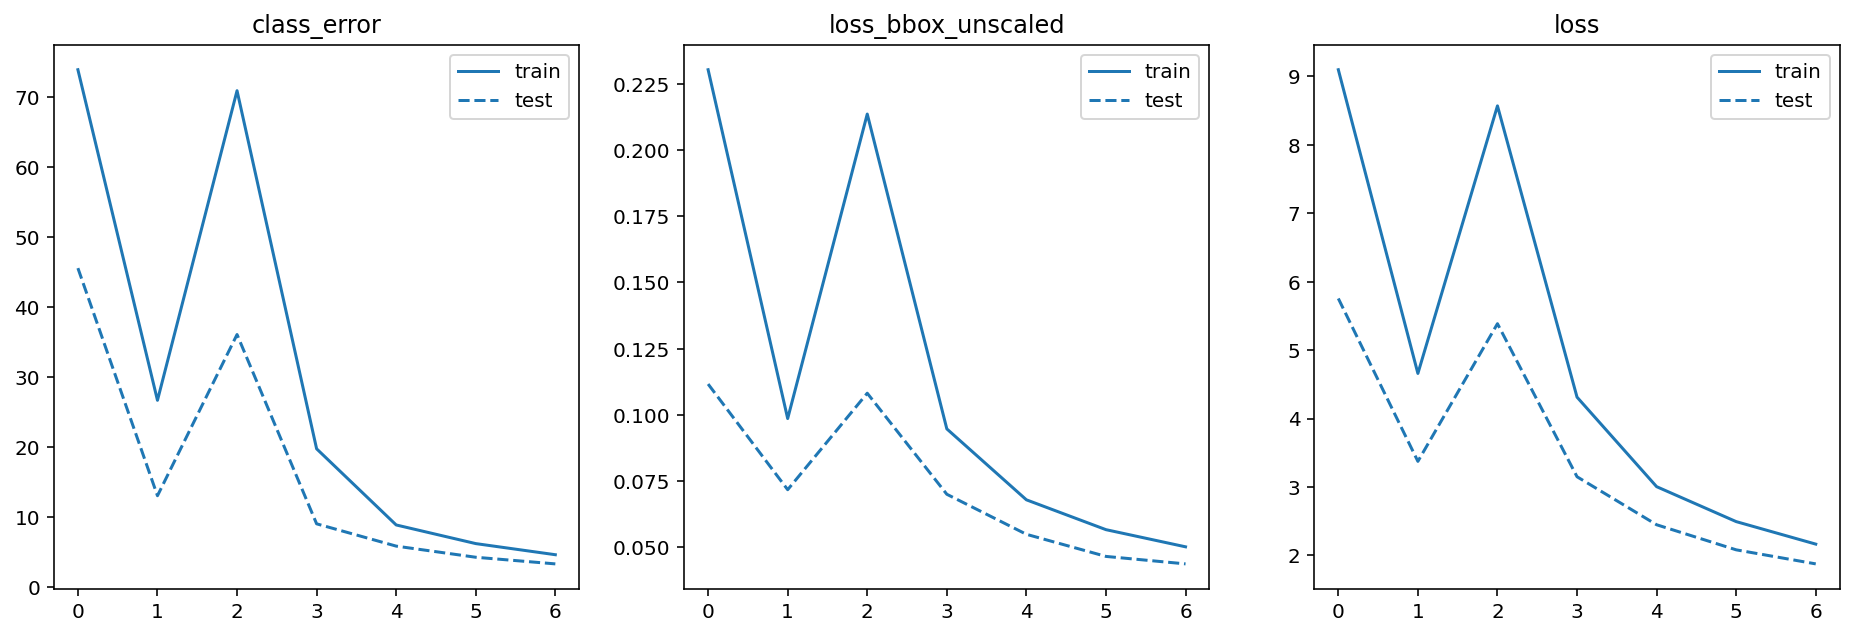

In [52]:
plot_logs(logs=['./outputs'], fields=('class_error', 'loss_bbox_unscaled', 'loss'))